# Description

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats
import numpy as np
import csv
import os
import shutil

# Parameters

In [2]:
assembly = "./data/final.p_ctg.fasta"
coverage_per_contig = "./data/heliopora_coerulea_hifi_2_p_assembly.coverage"
coverage_per_base = "./data/heliopora_coerulea_hifi_2_p_assembly.depth"
out_dir = "out_dir/"
min_contig_size = 100000
chunk_size = 10000
visualize_GC = False
save_GC_plot = False
visualize_Coverage = False
save_coverage_plot = False
visualize_histogram = True
save_histogram_plot = True
threshold_pct = 50
visualize_blob = True
save_blob_plot = True
plot_min_length = 100000
n_clusters = 2
len_to_Blast = 1000
space_to_Blast = 10000

# Naive GC content for each content

In [3]:
def get_gc_content(fasta_file):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to their GC content
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    #remove if current_seq y min_contig_size
                    if len(current_seq) > min_contig_size:
                        gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
                        
                # Start the new contig
                current_id = line.strip()[1:].split("/")[3]
                current_seq = ""
            else:
                current_seq += line.strip()
    
    # Calculate GC content for the final contig
    gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
    
    return gc_content

In [4]:
naive_gc = get_gc_content(assembly)
#print(naive_gc)
print(len(naive_gc))

670


# GC content for each contig by averaging in given chunk sizes

In [5]:
def get_gc_content_chunks(fasta_file, chunk_size):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to a list of gc content per chunk size
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    chunks = []
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    #remove if current_seq < min_contig_size
                    if len(current_seq) > min_contig_size:  
                        i = 0
                        while i < len(current_seq):
                            # check for last chunk
                            if (i + chunk_size) > len(current_seq):
                                end = len(current_seq)
                            else:
                                end = i + chunk_size
                            sub = current_seq[i:end]
                            gc = round(((sub.count("G") + sub.count("C")) / len(sub)),2)
                            chunks.append(gc)
                            i = end
                        # add to dictionary in form {current_id : [array of GC content of given chunk size]}
                        gc_content[current_id] = [chunks, len(current_seq)]

                # Start the new contig
                current_id = line.strip()[1:].split("/")[3]
                current_seq = ""
                chunks = []
                
            else:
                current_seq += line.strip()
                
        # calculate GC content for the last contig
        if current_id is not None:
            i = 0
            while i < len(current_seq):
                # check for last chunk
                if (i + chunk_size) > len(current_seq):
                    end = len(current_seq)
                else:
                    end = i + chunk_size
                sub = current_seq[i:end]
                gc = round(((sub.count("G") + sub.count("C")) / len(sub)), 2)
                chunks.append(gc)
                i = end
            # add to dictionary in form {current_id : [array of GC content of given chunk size, length]}
            gc_content[current_id] = [chunks, len(current_seq)]
        
    return gc_content

In [6]:
chunks = get_gc_content_chunks(assembly, chunk_size)
gc_trimmed_mean = {}
#Get the trimmed mean from chunks
for entry in chunks:
    length = chunks.get(entry)[1]
    avg_cov = chunks.get(entry)[0]
    gc_trimmed_mean[entry] = [stats.trim_mean(avg_cov, 0.05), length]
#print(gc_trimmed_mean)

# Visualize GC content 

In [7]:
if save_GC_plot:
    save_dir = out_dir + "./GC_visual_output"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

if visualize_GC:
    for id, gc_content in chunks.items():
        #format id
        id = id.split("/")[3]
        
        # create a bar plot
        fig, ax = plt.subplots()
        mean_gc = np.mean(gc_content)
        colors = ['red' if abs(gc - mean_gc) / mean_gc * 100 >= threshold_pct else 'blue' for gc in gc_content]
        plt.bar(range(len(gc_content)), gc_content, color=colors)
        ax.axhline(y=gc_trimmed_mean[id], color='black')
        plt.title("Contig: " + str(id))
        plt.xlabel('index of Chunk of size: ' + str(chunk_size))
        plt.ylabel('GC content')

        # save the plot
        if save_GC_plot:
            save_path = os.path.join(save_dir, "GC_content_" + str(id) + ".png")
            plt.savefig(save_path)

        # show the plot
        plt.show()

else:
    print("GC visualization is turned off.")

GC visualization is turned off.


# Naive coverage

In [8]:
def get_coverage_per_contig(coverage_file):
    naive_coverage = {}

    with open(coverage_file, "r") as f:
        next(f)
        for line in f:
            # Split line into columns
            columns = line.strip().split("\t")

            #only add if length > min_contig_size
            if (int(columns[2]) - int(columns[1])) > min_contig_size:
                # Use the first column as key and the sixth column as value
                key = columns[0].split("/")[3]
                value = columns[6]
                length = int(columns[2]) - int(columns[1])

                # Add key-value pair to dictionary
                naive_coverage[key] = [float(value), length]
            
    f.close()
    return naive_coverage

In [9]:
naive_coverage = get_coverage_per_contig(coverage_per_contig)
print(len(naive_coverage))

669


# Chunk averaged Coverage

In [10]:
def get_coverage_per_contig_by_chunks(depth_file, chunk_size):
    save_dir = out_dir + "Coverage_output/"
    
    # Define a dictionary to store the coverage data for each ID
    id_data = {}

    # Read in the TSV file
    with open(depth_file, 'r') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')

        # Iterate over each row in the file
        for row in reader:
            # Extract the ID, index, and coverage from the row
            id = row[0].split("/")[3]
            index = int(row[1])
            coverage = float(row[2])

            # Check if this is the first row for this ID
            if id not in id_data:
                id_data[id] = []

            # Find the window index for this row
            window_index = index // chunk_size

            # Check if there is already coverage data for this window
            if len(id_data[id]) <= window_index:
                # Add a new entry for this window
                id_data[id].append({'window_sum': coverage, 'window_count': 1})
            else:
                # Add the coverage to the existing window data
                id_data[id][window_index]['window_sum'] += coverage
                id_data[id][window_index]['window_count'] += 1            
                
          
    # Write the output to a file
    with open(save_dir + "chunked_windows_coverage.tsv", 'w') as outfile:
        outfile.write("id\tindex\taverage_coverage\n")
        for id, windows in id_data.items():
            #check total length > min_contig_size
            total_len = 0
            for i, window in enumerate(windows):
                total_len += window['window_count']
                if total_len > min_contig_size:
                    for i, window in enumerate(windows):
                        if window['window_count'] > 0:
                            avg_coverage = round((window['window_sum'] / window['window_count']), 2)
                            outfile.write(f"{id}\t{i}\t{avg_coverage}\n")
                        
        outfile.close()
    
    #now get the average coverage for each id
    # Open the input file
    with open(save_dir + "chunked_windows_coverage.tsv", "r") as f:
        next(f)
        # Create a dictionary to store the total coverage and highest index for each id
        id_coverage = {}
        # Read through each line in the file
        for line in f:
            # Split the line into three columns
            id, index, coverage = line.strip().split("\t")
            # Convert the coverage to float
            index = float(index)
            coverage = float(coverage)
            # If the id is not in the dictionary yet, add it with a coverage of 0 and index of -1
            if id not in id_coverage:
                id_coverage[id] = {"coverage": 0, "max_index": -1}
            # Add the coverage to the total for this id
            id_coverage[id]["coverage"] += coverage
            # Update the max index for this id if the current index is higher
            if index > id_coverage[id]["max_index"]:
                id_coverage[id]["max_index"] = index
    f.close()
    
    #make list of coverages, then take trimmed mean of that list
    coverage_trimmed_mean = {}
    for entry in id_data:
        coverages = []
        for chunk in id_data.get(entry):
            window_sum = float(chunk.get('window_sum'))
            window_count = float(chunk.get('window_count'))
            coverage = round((window_sum / window_count), 2)
            coverages.append(coverage)
        
        coverage_trimmed_mean[entry] = round(stats.trim_mean(coverages, 0.05), 2)
        
    # Open the output file
    with open(save_dir + "chunked_coverage.tsv", "w") as f:
        # Write the header row
        f.write("id\taverage_coverage\n")
        # Loop through the ids in the dictionary
        for id in coverage_trimmed_mean:
            average_coverage = coverage_trimmed_mean[id]
            f.write("{}\t{}\n".format(id, average_coverage))
    f.close()

    return id_data

In [11]:
chunks_coverage = get_coverage_per_contig_by_chunks(coverage_per_base, chunk_size)
len(chunks_coverage)

3348

# Visualize Coverage

In [12]:
save_dir = out_dir + "Coverage_output/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#windows
data = pd.read_csv(save_dir + "chunked_windows_coverage.tsv", dtype={'id': 'object'}, sep = "\t")
trimmed_mean = pd.read_csv(save_dir + "chunked_coverage.tsv", dtype={'id': 'object'}, sep = "\t")

# Convert data to pandas dataframe
df = pd.DataFrame(data)
mean = pd.DataFrame(trimmed_mean)
# Group data by id
groups = df.groupby('id')
# Get a list of unique ids
unique_ids = df['id'].unique()
    
if visualize_Coverage:
    # Create a separate plot for each id
    for id in unique_ids:
        # Filter the dataframe to get only the rows for this id
        df_id = df[df['id'] == id]
        
        fig, ax = plt.subplots()
        trimmed_mean_coverage = float(mean.loc[mean['id'] == id, 'average_coverage'])
        ax.axhline(y=trimmed_mean_coverage, color='black')

        #filtered colors
        colors = ['red' if abs(coverage - trimmed_mean_coverage) / trimmed_mean_coverage * 100 >= threshold_pct else 'blue' for coverage in df_id['average_coverage']]

        # Plot the data for this id
        plt.bar(df_id['index'], df_id['average_coverage'], label=f"id={id}", color=colors)
        
        # Add labels and legend
        plt.xlabel('Index of chunk size ' + str(chunk_size))
        plt.ylabel('Average coverage')

        # save the plot
        if save_coverage_plot:
            save_path = os.path.join(save_dir, "Coverage_" + str(id) + ".png")
            plt.savefig(save_path)
        
        # Show the plot
        plt.show()
        
else :
    print("Coverage visualization is turned off.")

Coverage visualization is turned off.


# Blob Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         id  gc_content  average_coverage  length
0    000409    0.436113          22.83830  360234
1    000412    0.368200         160.75100  359643
2    000414    0.432141          19.88960  328049
3    000417    0.383678          64.71960  354817
4    000419    0.477587           7.80256  352580
..      ...         ...               ...     ...
664  001104    0.443216          23.02950  100661
665  001105    0.490182           3.58853  100584
666  001106    0.428038           5.00850  100420
667  001107    0.626786           6.32119  100290
668  001127    0.551796           3.17078  100460

[669 rows x 4 columns]


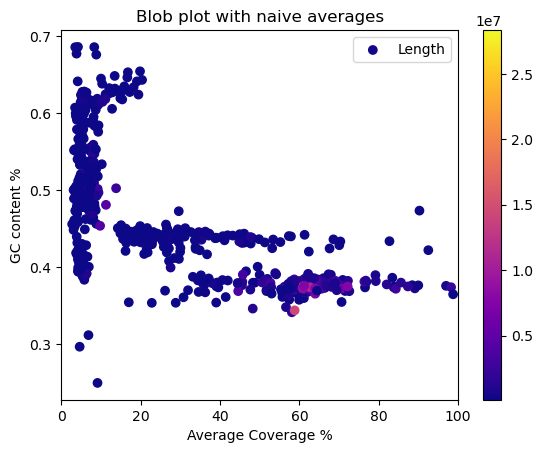

In [13]:
#plot gc content (x) vs coverage (y)
if visualize_blob:
    
    #plot 1 naive
    data = [{'id': k, 'gc_content': v} for k, v in naive_gc.items()]
    data2 = [{'id': k, 'average_coverage': v[0], 'length': v[1]} for k, v in naive_coverage.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    df2 = pd.DataFrame(data2)
    naive_df = pd.merge(df1, df2, on = 'id')
    naive_df = naive_df[naive_df['length'] >= plot_min_length]
    print(naive_df)
    
    fig, ax = plt.subplots()
    ax.set_xlim([0, 100])
    cmap = plt.matplotlib.colormaps.get_cmap('plasma')
    
    sc = plt.scatter(naive_df['average_coverage'], naive_df['gc_content'],  c = naive_df['length'], cmap = cmap)
    cbar = plt.colorbar(sc)
    # Add labels and legend
    plt.xlabel('Average Coverage %')
    plt.ylabel('GC content %')
    plt.title('Blob plot with naive averages')
    plt.legend(loc="upper right")
    ax.legend([sc], ['Length'], loc="upper right")
    
    # save the plot
    if save_blob_plot:
        save_path = os.path.join(out_dir, "Blob_naive.png")
        plt.savefig(save_path)

    # Show the plot
    plt.show()

         id  gc_content  length  average_coverage
0    000409    0.436857  360235             22.45
1    000412    0.369412  359644            156.09
2    000414    0.433226  328050             20.07
3    000417    0.384412  354818             64.86
4    000419    0.477941  352581              7.72
..      ...         ...     ...               ...
664  001104    0.440000  100662             21.41
665  001105    0.492727  100585              3.62
666  001106    0.429091  100421              4.83
667  001107    0.630909  100291              6.03
668  001127    0.550000  100461              3.16

[669 rows x 4 columns]


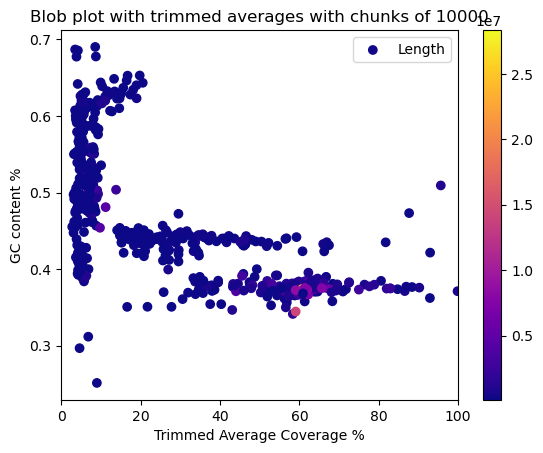

In [14]:
if visualize_blob:
    #plot 2 trimmed/chunked
    
    data = [{'id': k, 'gc_content': v[0], 'length' : v[1]} for k, v in gc_trimmed_mean.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    trimmed_df = pd.merge(df1, trimmed_mean, on = 'id')
    trimmed_df = trimmed_df[trimmed_df['length'] >= plot_min_length]
    print(trimmed_df) 
    
    fig, ax = plt.subplots()
    ax.set_xlim([0, 100])
    cmap = plt.matplotlib.colormaps.get_cmap('plasma')
    
    #labels = list(trimmed_df['id'])
    sc1 = plt.scatter(trimmed_df['average_coverage'], trimmed_df['gc_content'], c = trimmed_df['length'], cmap = cmap)
    cbar = plt.colorbar(sc1)
    # Add labels and legend
    plt.xlabel('Trimmed Average Coverage %')
    plt.ylabel('GC content %')
    plt.title('Blob plot with trimmed averages with chunks of ' + str(chunk_size))
    ax.legend([sc1], ['Length'], loc="upper right")
    
    # save the plot
    if save_blob_plot:
        save_path = os.path.join(out_dir, "Blob.png")
        plt.savefig(save_path)

    # Show the plot
    plt.show()

# Histogram of contig lengths

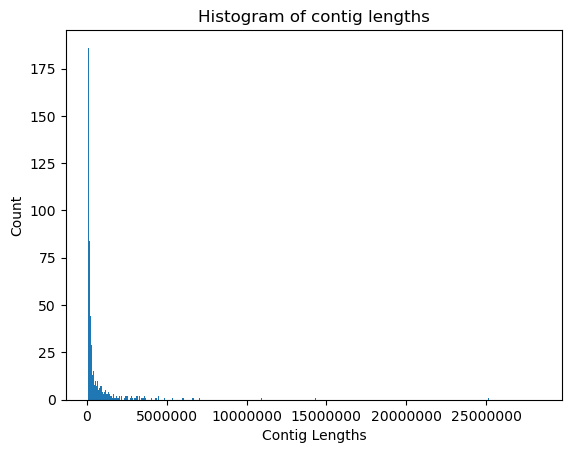

In [15]:
#Histogram of all contig lengths

if visualize_histogram:
    data = trimmed_df["length"]
    #print(data)
    
    fig, ax = plt.subplots()
    plt.hist(data, len(data))
    ax.ticklabel_format(style='plain', axis='x')
    
    plt.xlabel('Contig Lengths')
    plt.ylabel('Count')
    plt.title('Histogram of contig lengths')
    
    # save the plot
    if save_histogram_plot:
        save_path = os.path.join(out_dir, "Histogram_of_lengths.png")
        plt.savefig(save_path)

    # Show the plot
    plt.show()

# K-Means

Using this plot you will need to select which cluster is the main cluster for the next step
total length of cluster 0 : 441283783
Using this plot you will need to select which cluster is the main cluster for the next step
total length of cluster 1 : 119741358


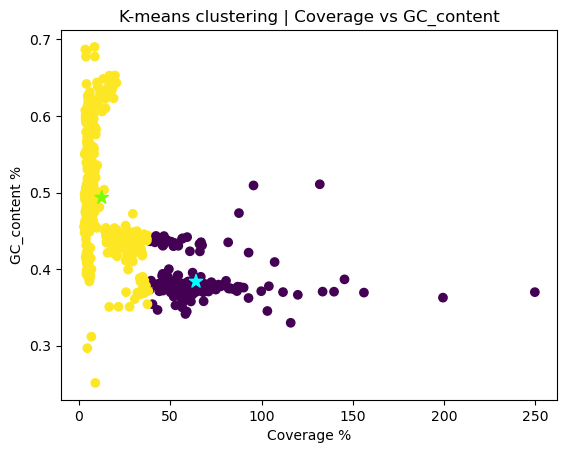

In [22]:
#kmeans to get clusters in blob plots
np.random.seed(42)

coverage = trimmed_df['average_coverage']
gc_content = trimmed_df['gc_content']
ids = trimmed_df['id'].values

#make a feature matrix
X = np.column_stack((coverage, gc_content))

#kmeans clusters = n_clusters
kmeans = KMeans(n_clusters, random_state = 42, n_init='auto').fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#create a dictionary for each cluster
cluster_points = {i: [] for i in range(len(centroids))}

#add the ids to each cluster in the dictionary
for i, label in enumerate(labels):
    cluster_points[label].append(ids[i])

#look up each point in dataframe to get length
for cluster in cluster_points:
    total_cluster_length = 0
    
    print('Using this plot you will need to select which cluster is the main cluster for the next step')
    #for each id for each cluster into a seperate file
    with open(out_dir + 'cluster_info/cluster_' + str(cluster) + '.txt', 'w') as out:
        for i in cluster_points[cluster]:
            #write ids into output
            out.write(i + '\n')
            
            #get length and total length
            length = trimmed_df.loc[trimmed_df['id'] == i, 'length'].iloc[0]
            total_cluster_length += length
    print('total length of cluster ' + str(cluster) + ' : ' + str(total_cluster_length))
    
colors = ['aqua', 'lawngreen']
#plotting
plt.scatter(X[:,0], X[:,1], c = labels)
plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = colors)
plt.xlabel('Coverage %')
plt.ylabel('GC_content %')
plt.title('K-means clustering | Coverage vs GC_content')
plt.show()

# Making Fasta with ids in target cluster

In [26]:
#Set target cluster 
target_cluster = 1

In [27]:
#for each id in cluster 0 get the sequence and write into a fasta file
    #we already have a fasta file with these ids, we just need to extract only the ones we are interested in
with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.fasta', 'w') as fasta:
    with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.txt', 'r') as cluster:
        for line in cluster:
            header = line.strip()
            #write header
            fasta.write('>' + header + '\n')
            #before next header write line for sequence
            #search for the header line in assembly which includes header
            with open(assembly, 'r') as big:
                found = False
                for line in big:
                    if found:
                        sequence = line.strip()
                        found = False
                        break
                    if header in line:
                        found = True
            big.close()
            fasta.write(str(sequence) + '\n')
    
    cluster.close()
fasta.close()

In [30]:
#Split each entry in fasta file, i.e every 10k take 1k sample
#for each entry in fasta file, if length > 10000 then take small chunk every 10000bp

with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.fasta', 'r') as fasta:
    for line in fasta:
        if '>' in line:
            #write in split_contigs
            #print(line)
            line = ''.join(line.split())
            contig_name = str(line.replace('>', ''))
        else:
            with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '/split_contigs/' + contig_name + '.fasta', 'w') as contig_file:
                #split into substrings of len_to_Blast every space_to_Blast
                length = len(line)
                #print(length)
                if length > (space_to_Blast + len_to_Blast):
                    #loop
                    pos = 0
                    while pos < length:
                        start = pos
                        end = pos + len_to_Blast
                        #header = startpos endpos
                        #sequence = sequence
                        seq = (line[start:end] + '\n')
                        header = ('>' + str(start) + ' : ' + str(end) + '\n')
                        pos += space_to_Blast + len_to_Blast
                        contig_file.write(header)
                        contig_file.write(seq)
                
            contig_file.close()
            
fasta.close()